---
# How to Run the Code
---

To successfully run the provided code in this notebook, please follow these steps:

- Install Python (version 3.7 or later).
- Use `pip` to install the necessary libraries. Run the following command: ```pip install numpy pandas matplotlib pytest```
- Ensure the file `final.py` (containing the core functionality) is in the same directory as this notebook.
- Ensure that any CSV or Markdown files required for execution are accessible in the correct relative paths.
- Open this notebook using Jupyter: ```jupyter notebook final.ipynb```
- Execute the cells sequentially.
- To validate the code functionality, run the test suite using `pytest`: pytest ```test_final.py```
- The notebook will demonstrate:
    - Data processing from Markdown and CSV files.
    - Sine function fitting using gradient descent.
    - FFT and inverse FFT for signal analysis.
---
# Bibliography
---

This project utilized the following resources and libraries:

**1) Python Libraries**:
   - *NumPy*: Fundamental package for numerical computations.
     - [NumPy Official Documentation](https://numpy.org/doc/)
   - *Pandas*: Library for data manipulation and analysis.
     - [Pandas Official Documentation](https://pandas.pydata.org/)
   - *Matplotlib*: Plotting and visualization library.
     - [Matplotlib Official Documentation](https://matplotlib.org/)
   - *Pytest*: Framework for testing Python code.
     - [PyTest Official Documentation](https://docs.pytest.org/)
   - *Pylint*: Framework for checking code compliance to PEP standards.
     - [PyLint Official Documentation](https://pylint.pycqa.org/)
       
**2) Gradient Descent and Optimization**:
     - Bottou, L. (2010). "Large-Scale Machine Learning with Stochastic Gradient Descent." Proceedings of COMPSTAT'2010.
     
**3) Signal Processing**:
     - Oppenheim, A.V., Schafer, R.W., & Buck, J.R. (1999). "Discrete-Time Signal Processing." 2nd Edition.
     
**4) Markdown Parsing**:
    - [Markdown Documentation](https://daringfireball.net/projects/markdown/)
    
**5) PhyPhox App**: Physical Phone Experiments (https://phyphox.org)

---

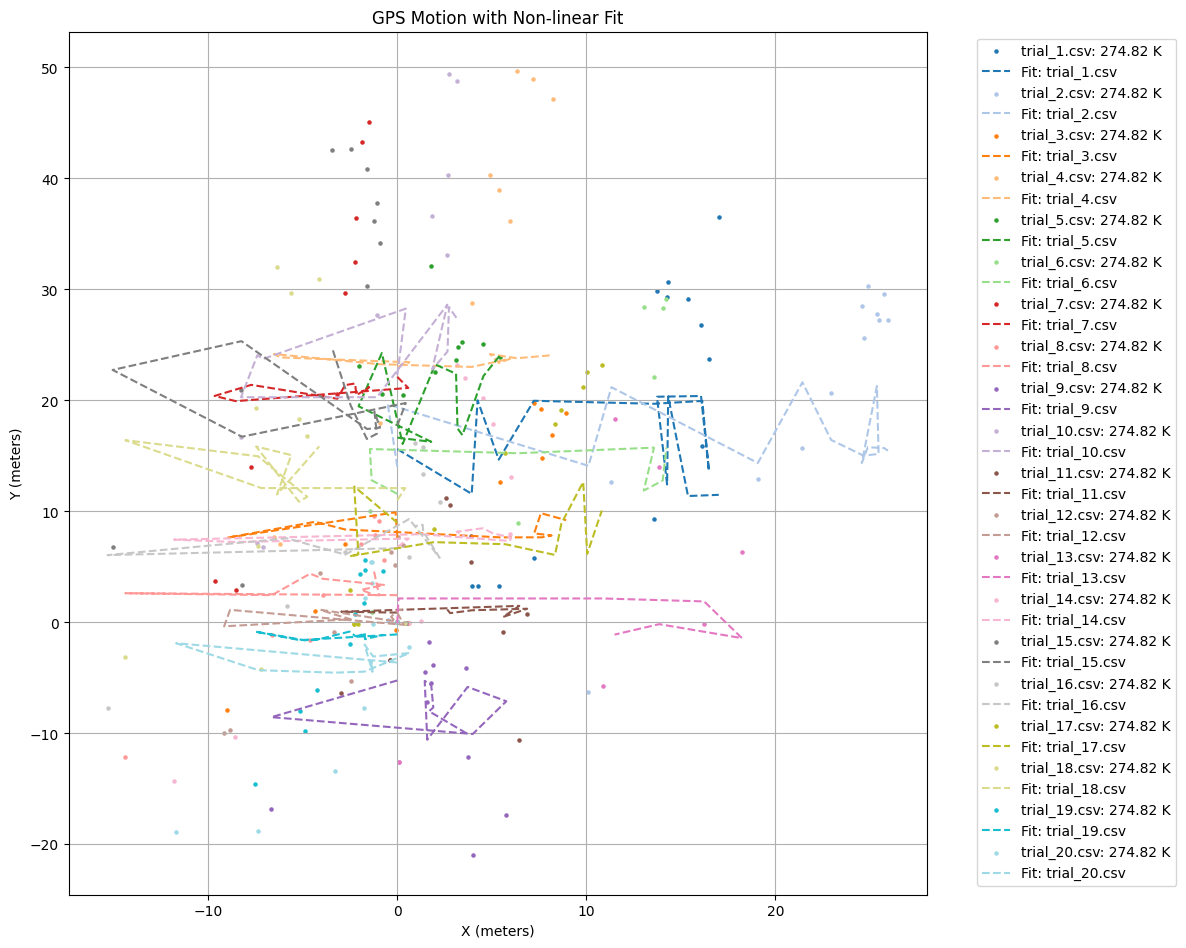

In [4]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from final import parse_temperature_from_markdown, fahrenheit_to_kelvin, non_linear_fitting, sine_function

# Define GPS to Cartesian conversion function
def gps_to_cartesian(lat, lon, origin_lat, origin_lon, altitude=0):
    """
    Convert GPS coordinates to Cartesian coordinates with the origin as the starting point.

    Parameters:
        lat (np.array): Latitude in degrees.
        lon (np.array): Longitude in degrees.
        origin_lat (float): Origin latitude in degrees.
        origin_lon (float): Origin longitude in degrees.
        altitude (float): Altitude in meters (default: 0).

    Returns:
        tuple: Cartesian coordinates (x, y) in meters relative to the origin.
    """
    R = 6371000  # Earth's radius in meters
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    origin_lat_rad = np.radians(origin_lat)
    origin_lon_rad = np.radians(origin_lon)

    # Cartesian conversion
    x = (lon_rad - origin_lon_rad) * R * np.cos(origin_lat_rad)
    y = (lat_rad - origin_lat_rad) * R

    return x, y

# Define function to adjust step power
def adjust_step_power(data_length, desired_step_power):
    """
    Adjust the step power dynamically based on the data length.

    Parameters:
        data_length (int): The length of the data.
        desired_step_power (int): The desired step power.

    Returns:
        int: Adjusted step power to ensure the step size is valid.
    """
    max_power = int(np.log2(data_length))  # Maximum power of 2 less than data length
    return min(desired_step_power, max_power - 1)

# Process each GPS file and generate the plot
def process_gps_and_plot(csv_files, md_files):
    plt.figure(figsize=(12, 10))

    cmap = plt.get_cmap('tab20')  # Use a colormap with enough distinct colors for 20 files
    colors = [cmap(i) for i in range(len(csv_files))]

    for idx, (csv_file, md_file) in enumerate(zip(csv_files, md_files)):
        try:
            # Load GPS data
            gps_data = pd.read_csv(csv_file)
            latitude = gps_data['Latitude (°)']
            longitude = gps_data['Longitude (°)']
            origin_lat = latitude.iloc[0]
            origin_lon = longitude.iloc[0]

            # Convert to Cartesian coordinates
            x, y = gps_to_cartesian(latitude.to_numpy(), longitude.to_numpy(), origin_lat, origin_lon)

            # Read temperature
            temp_fahrenheit = parse_temperature_from_markdown(md_file)
            if temp_fahrenheit is not None:
                temp_kelvin = fahrenheit_to_kelvin(temp_fahrenheit)
            else:
                continue

            # Estimate initial parameters for sine fitting
            amplitude_guess = (max(y) - min(y)) / 2
            offset_guess = np.mean(y)
            frequency_guess = 1 / (max(x) - min(x)) if max(x) > min(x) else 0.01
            phase_guess = 0
            initial_params = [amplitude_guess, frequency_guess, phase_guess, offset_guess]

            # Adjust step power based on data length
            step_power = adjust_step_power(len(x), desired_step_power=5)

            # Non-linear fit
            try:
                fitted_params = non_linear_fitting({
                    "x_data": x,
                    "y_data": y,
                    "fit_function": sine_function,
                    "initial_params": initial_params,
                    "step_power": step_power,
                    "learning_rate": 0.01,
                    "max_iterations": 2000,
                })

                # Plot data points and fitted curve
                plt.scatter(x, y, s=5, color=colors[idx], label=f'{csv_file}: {temp_kelvin:.2f} K')
                plt.plot(x, sine_function(x, *fitted_params), color=colors[idx], linestyle='--', label=f'Fit: {csv_file}')
            except Exception as e:
                print(f"Error fitting data for {csv_file}: {e}")
                continue

        except KeyError as e:
            print(f"Key error processing {csv_file}: {e}")
            continue
        except FileNotFoundError as e:
            print(f"File not found: {e}")
            continue
        except Exception as e:
            print(f"Unexpected error: {e}")
            continue

    plt.xlabel('X (meters)')
    plt.ylabel('Y (meters)')
    plt.title('GPS Motion with Non-linear Fit')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()
    plt.tight_layout()
    plt.show()

# Run the processing function
process_gps_and_plot(csv_files, md_files)


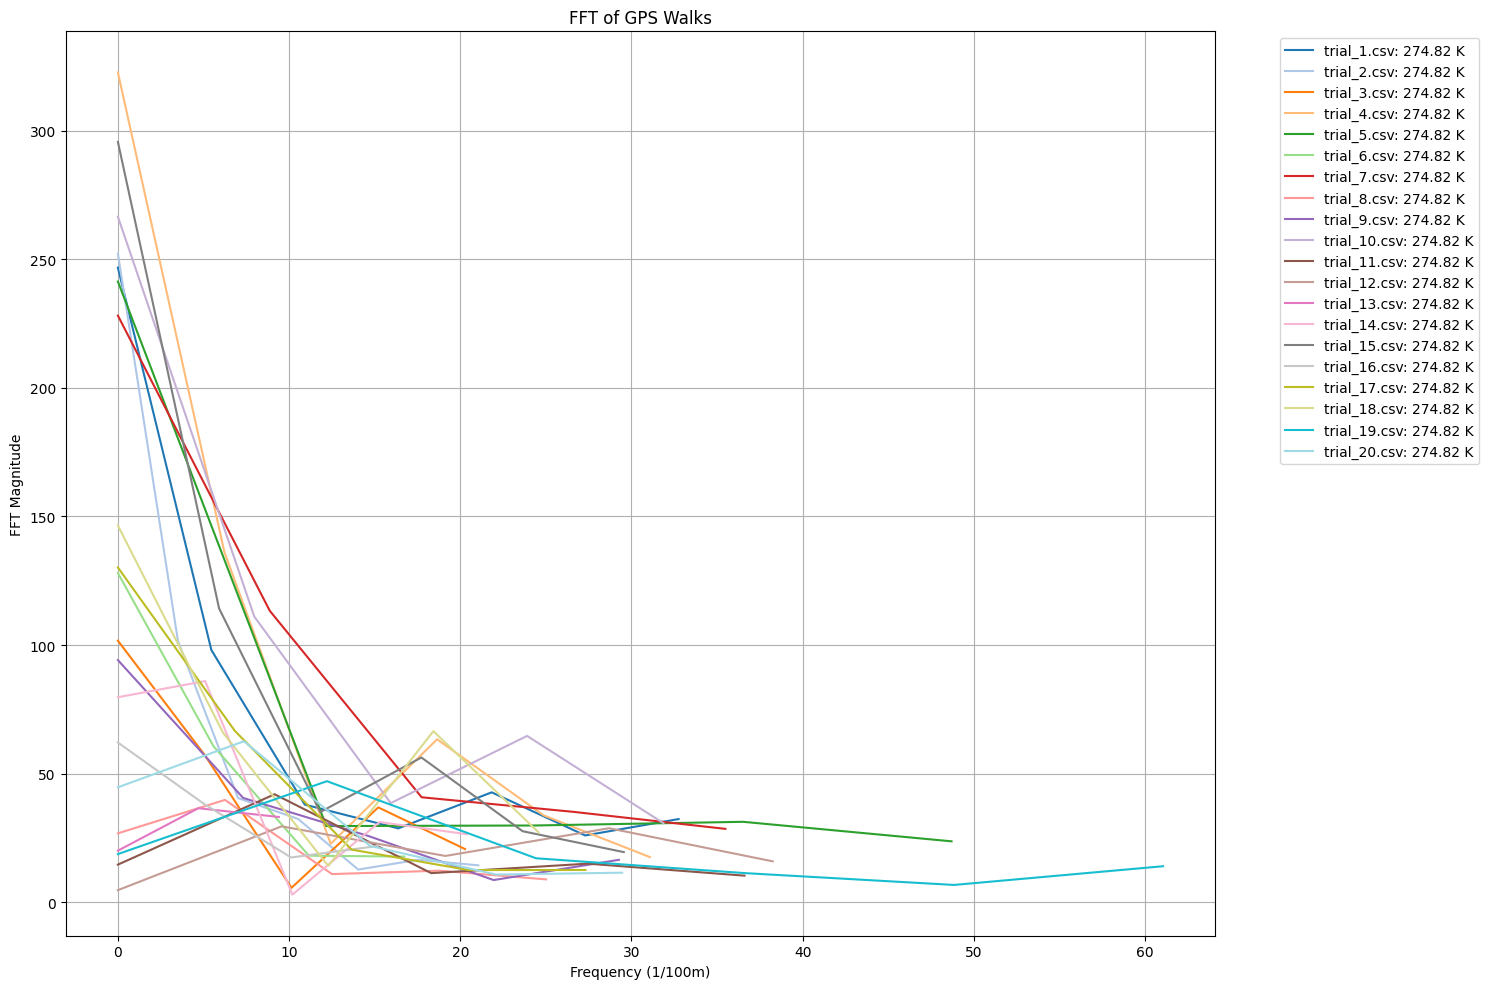

In [5]:
def fft_with_units(x, y):
    """
    Compute the FFT for GPS data and convert frequency to units of 1/100m.

    Parameters:
        x (np.array): X-coordinates in meters.
        y (np.array): Y-coordinates in meters.

    Returns:
        tuple: Frequencies in units of 1/100m and corresponding FFT values.
    """
    # Remove duplicate x-values and sort
    unique_indices = np.unique(x, return_index=True)[1]
    x = x[unique_indices]
    y = y[unique_indices]
    
    # Ensure x is strictly increasing
    if np.any(np.diff(x) <= 0):
        raise ValueError("Non-positive or non-monotonic step size in x-coordinates.")

    dx = np.mean(np.diff(x))  # Mean step size
    if dx <= 0:
        raise ValueError("Non-positive step size in x-coordinates.")

    # FFT computation
    n = len(y)
    fft_values = np.fft.fft(y)
    freqs = np.fft.fftfreq(n, d=dx)

    # Convert frequencies to units of 1/100m
    freqs = freqs * 100
    return freqs[:n // 2], np.abs(fft_values[:n // 2])  # Only positive frequencies

# Plot FFTs for each GPS file
def plot_fft_of_walks(csv_files, md_files):
    plt.figure(figsize=(15, 10))
    cmap = plt.get_cmap('tab20')  # Use a colormap with enough distinct colors for all files
    colors = [cmap(i) for i in range(len(csv_files))]

    for idx, (csv_file, md_file) in enumerate(zip(csv_files, md_files)):
        try:
            # Load GPS data
            gps_data = pd.read_csv(csv_file)
            latitude = gps_data['Latitude (°)']
            longitude = gps_data['Longitude (°)']
            origin_lat = latitude.iloc[0]
            origin_lon = longitude.iloc[0]

            # Convert to Cartesian coordinates
            x, y = gps_to_cartesian(latitude.to_numpy(), longitude.to_numpy(), origin_lat, origin_lon)

            # Read temperature for legend
            temp_fahrenheit = parse_temperature_from_markdown(md_file)
            if temp_fahrenheit is not None:
                temp_kelvin = fahrenheit_to_kelvin(temp_fahrenheit)
            else:
                temp_kelvin = None

            # FFT calculation
            frequencies, fft_values = fft_with_units(x, y)

            # Plot FFT
            plt.plot(
                frequencies, fft_values, color=colors[idx],
                label=f'{csv_file}: {temp_kelvin:.2f} K' if temp_kelvin else csv_file
            )

        except Exception as e:
            print(f"Error processing {csv_file}: {e}")

    plt.xlabel('Frequency (1/100m)')
    plt.ylabel('FFT Magnitude')
    plt.title('FFT of GPS Walks')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()
    plt.tight_layout()
    plt.show()

plot_fft_of_walks(csv_files, md_files)

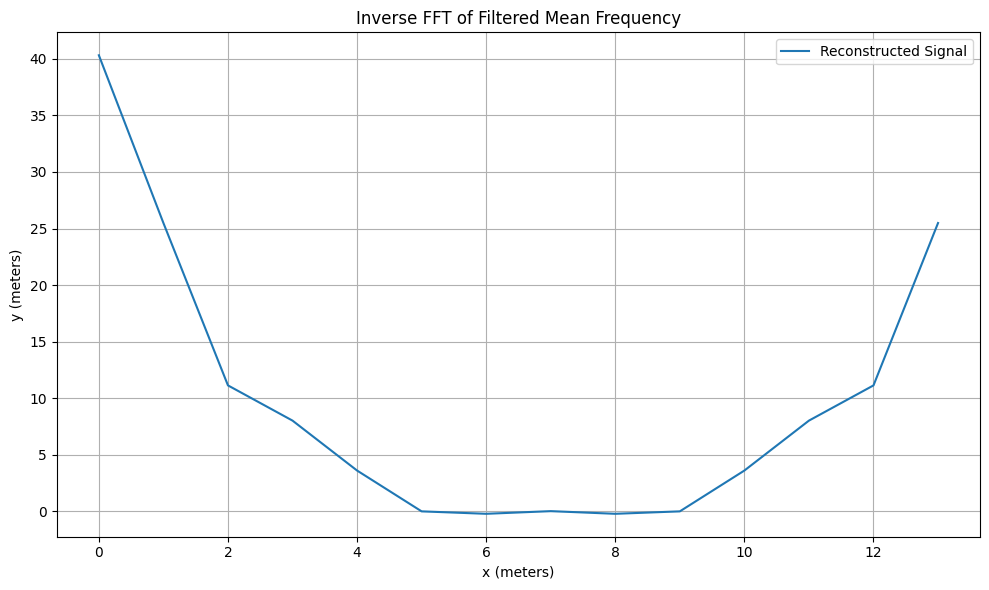

In [6]:
def inverse_fft_filtered_mean(csv_files):
    """
    Generate a figure that shows the inverse FFT of the filtered mean value
    of the sine walk frequency.

    Parameters:
        csv_files (list): List of CSV file paths containing GPS data.
    """
    fft_sums = []
    max_length = 0

    # Compute the mean FFT across all walks
    for csv_file in csv_files:
        try:
            # Load GPS data
            gps_data = pd.read_csv(csv_file)
            latitude = gps_data['Latitude (°)']
            longitude = gps_data['Longitude (°)']
            origin_lat = latitude.iloc[0]
            origin_lon = longitude.iloc[0]

            # Convert to Cartesian coordinates
            x, y = gps_to_cartesian(latitude.to_numpy(), longitude.to_numpy(), origin_lat, origin_lon)

            # FFT calculation
            frequencies, fft_values = fft_with_units(x, y)

            # Ensure FFT values are of the same length
            max_length = max(max_length, len(fft_values))
            fft_sums.append(fft_values)
        except Exception as e:
            print(f"Error processing {csv_file}: {e}")

    # Standardize FFT length and compute the mean
    standardized_ffts = []
    for fft in fft_sums:
        padded_fft = np.zeros(max_length)
        padded_fft[:len(fft)] = fft  # Pad with zeros to match the maximum length
        standardized_ffts.append(padded_fft)

    # Compute mean FFT
    mean_fft = np.mean(standardized_ffts, axis=0)

    # Perform inverse FFT
    n = max_length * 2  # Reconstruct the original signal length
    inverse_signal = np.fft.ifft(np.concatenate([mean_fft, mean_fft[::-1]]))

    # Plot the reconstructed signal
    plt.figure(figsize=(10, 6))
    plt.plot(np.real(inverse_signal), label="Reconstructed Signal")
    plt.xlabel("x (meters)")
    plt.ylabel("y (meters)")
    plt.title("Inverse FFT of Filtered Mean Frequency")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

inverse_fft_filtered_mean(csv_files)